In [1]:
pwd()

"/home/xyu/github/BulkLMM.jl/test/run-gemma"

In [2]:
gemma = "/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64"

"/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64"

In [3]:
typeof(gemma)

String

In [4]:
run(`$gemma -h`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021

 type ./gemma -h [num] for detailed help
 options: 
  1: quick guide
  2: file I/O related
  3: SNP QC
  4: calculate relatedness matrix
  5: perform eigen decomposition
  6: perform variance component estimation
  7: fit a linear model
  8: fit a linear mixed model
  9: fit a multivariate linear mixed model
 10: fit a Bayesian sparse linear mixed model
 11: obtain predicted values
 12: calculate snp variance covariance
 13: note
 14: debug options

The GEMMA software is distributed under the GNU General Public v3
   -license    show license information
   see also http://www.xzlab.org/software.html, https://github.com/genetics-statistics


Process(`/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64 -h`, ProcessExited(0))

In [5]:
pheno_filename = "/home/xyu/github/BulkLMM.jl/test/run-gemma/BXDpheno_bimbam.txt";
geno_filename = "/home/xyu/github/BulkLMM.jl/test/run-gemma/BXDgeno_prob_bimbam.txt";

In [6]:
pwd()

"/home/xyu/github/BulkLMM.jl/test/run-gemma"

In [8]:
@time run(`$gemma -g $geno_filename -p $pheno_filename -gk 1 -o kinship`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 79
## number of analyzed individuals = 79
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Calculating Relatedness Matrix ... 
================================================== 100%


**** INFO: Done.


  0.447660 seconds (643 allocations: 49.562 KiB)


Process(`/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64 -g /home/xyu/github/BulkLMM.jl/test/run-gemma/BXDgeno_prob_bimbam.txt -p /home/xyu/github/BulkLMM.jl/test/run-gemma/BXDpheno_bimbam.txt -gk 1 -o kinship`, ProcessExited(0))

In [35]:
@time run(`$gemma -g $geno_filename -p $pheno_filename -k output/kinship.cXX.txt -lmm 1 -o gemma_results.txt`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 79
## number of analyzed individuals = 79
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Start Eigen-Decomposition...
pve estimate =0.813567
se(pve) =0.0950615
================================================== 100%
  1.114908 seconds (807 allocations: 60.414 KiB)


**** INFO: Done.


Process(`/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64 -g /home/xyu/github/BulkLMM.jl/test/run-gemma/BXDgeno_prob_bimbam.txt -p /home/xyu/github/BulkLMM.jl/test/run-gemma/BXDpheno_bimbam.txt -k output/kinship.cXX.txt -lmm 1 -o gemma_results.txt`, ProcessExited(0))

In [12]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Distributed
using Plots
using Profile

## Include the source code of BulkLMM to be tested:
include("../../src/scan.jl");
include("../../src/lmm.jl");
include("../../src/wls.jl");
include("../../src/util.jl");
include("../../src/kinship.jl");
include("../../src/readData.jl");

## Also include the helper functions for writing tests:
include("../../test/testHelper.jl");


## Read in BXD data:
pheno_file = "../../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate k

nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [33]:
var(pheno_y)

0.3345634803635185

In [21]:
@time scan(pheno_y, geno, kinship; reml = false, method = "alt");

  1.808055 seconds (2.53 M allocations: 1.165 GiB, 14.01% gc time)


In [22]:
bulklmm_results = scan(pheno_y, geno, kinship; reml = false, method = "alt");

In [23]:
bulklmm_results[2]

(0.4794784967134278, 0.8960637228414874, [0.008197761427618105, 0.008197761427618105, 0.008197761427618105, 0.008197761427618105, 0.008197761427618105, 0.008197761427618105, 0.008197761427627364, 0.008197761427627364, 0.008197761427618105, 0.008197761427618105  …  0.09535348724996476, 0.011536179594516653, 0.008268469217230835, 0.008268469217237005, 0.015117504699355279, 0.029166995976286986, 0.027506001225355292, 0.04535019721089358, 0.012992620923705364, 0.012992620923696106])

In [25]:
pwd()

"/home/xyu/github/BulkLMM.jl/test/run-gemma"

In [26]:
gemma_results = CSV.read("output/gemma_results.txt.assoc.txt", DataFrame, delim = '\t');

In [29]:
kinship[1:6, 1:6]

6×6 Matrix{Float64}:
 1.0       0.468763  0.561085  0.521296  0.502617  0.476443
 0.468763  1.0       0.482652  0.50435   0.431553  0.483647
 0.561085  0.482652  1.0       0.374733  0.443817  0.567154
 0.521296  0.50435   0.374733  1.0       0.577574  0.462847
 0.502617  0.431553  0.443817  0.577574  1.0       0.476722
 0.476443  0.483647  0.567154  0.462847  0.476722  1.0

In [30]:
pwd()

"/home/xyu/github/BulkLMM.jl/test/run-gemma"

In [31]:
kinship_file = "../../data/bxdData/BXDkinship.csv"

"../../data/bxdData/BXDkinship.csv"

In [34]:
# run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_file -lmm 2 -o gemma_results_sameK.txt`)

In [36]:
0.221055/(0.221055+0.0490897)

0.8182836827818573

In [39]:
kinship = CSV.read("output/kinship.cXX.txt", DataFrame, delim = '\t', header = false);

In [44]:
typeof(kinship)

DataFrame

In [51]:
kinship_Mat = Matrix(kinship);

In [66]:
results_bulklmm = scan(pheno_y, geno, kinship_Mat; reml = false, method = "alt");

In [67]:
results_bulklmm[2]

0.8398237379264945

In [68]:
results_bulklmm = scan(pheno_y, geno, kinship_Mat; reml = false, method = "");

In [69]:
p

7321

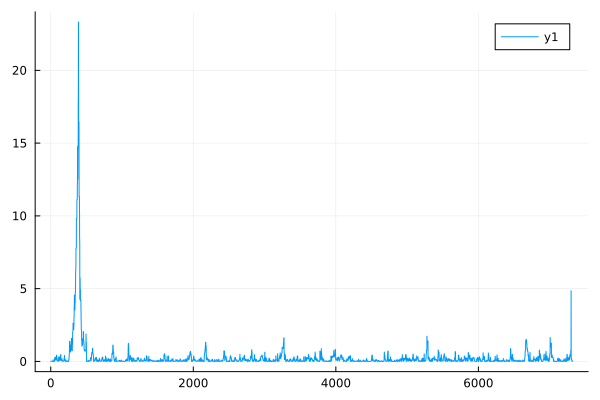

In [76]:
plot(results_bulklmm[3])

In [73]:
results_null = scan(pheno_y, geno, kinship_Mat; reml = false, method = "null");

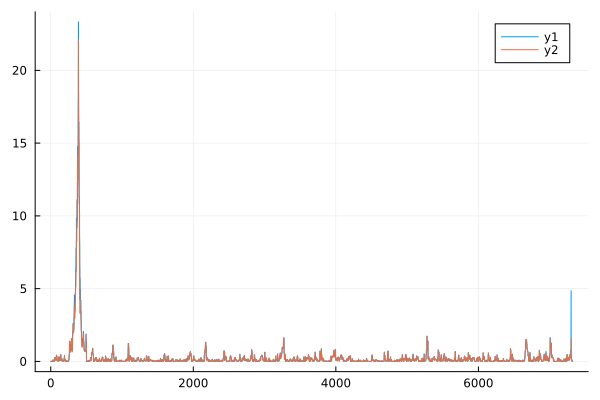

In [77]:
plot!(results_null[3])

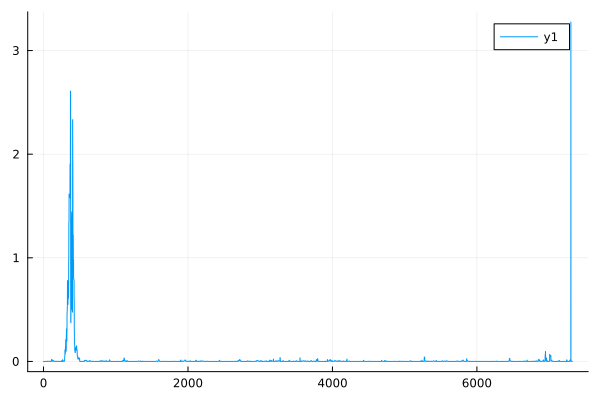

In [78]:
plot(results_bulklmm[3] .- results_null[3])

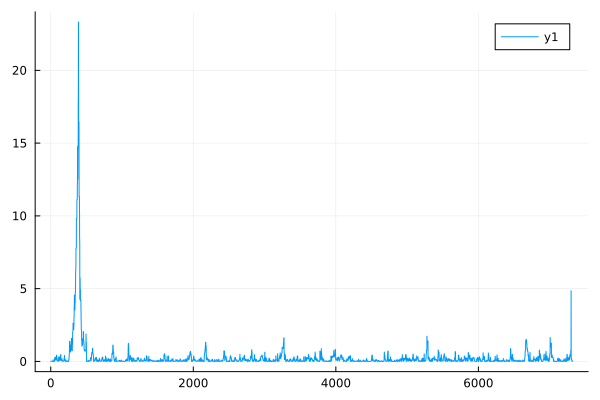

In [79]:
plot(results_bulklmm[3])